In [1]:
import jax.numpy as jnp
from jax import grad, vmap, hessian

import jax.ops as jop
from jax.config import config; 
config.update("jax_enable_x64", True)

# numpy
import numpy as onp
from numpy import random 

# Plot
import matplotlib.pyplot as plt

In [2]:
# up to 2nd derivatives

def kappa(x,y,d,sigma):
    dist2 = jnp.sum((x-y)**2)
    return jnp.exp(-dist2/(2*sigma**2))

def Delta_y_kappa(x,y,d,sigma):
    dist2 = jnp.sum((x-y)**2)
    val = (-d*(sigma**2)+dist2)/(sigma**4)*jnp.exp(-dist2/(2*sigma**2))
    return val


def Delta_x_kappa(x,y,d,sigma):
    dist2 = jnp.sum((x-y)**2)
    val = (-d*(sigma**2)+dist2)/(sigma**4)*jnp.exp(-dist2/(2*sigma**2))
    return val


def Delta_x_Delta_y_kappa(x,y,d,sigma):
    dist2 = jnp.sum((x-y)**2)
    val = ((sigma**4)*d*(2+d)-2*(sigma**2)*(2+d)*dist2+dist2**2)/(sigma**8)*jnp.exp(-dist2/(2*sigma**2))
    return val

def get_GNkernel_train(x,y,wx0,wx1,wy0,wy1,d,sigma):
    return wx0*wy0*kappa(x,y,d,sigma) + wx0*wy1*Delta_y_kappa(x,y,d,sigma) + wy0*wx1*Delta_x_kappa(x,y,d,sigma) + wx1*wy1*Delta_x_Delta_y_kappa(x,y,d,sigma)

def get_GNkernel_train_boundary(x,y,wy0,wy1,d,sigma):
    return wy0*kappa(x,y,d,sigma) + wy1*Delta_y_kappa(x,y,d,sigma)

def get_GNkernel_val_predict(x,y,wy0,wy1,d,sigma):
    return wy0*kappa(x,y,d,sigma) + wy1*Delta_y_kappa(x,y,d,sigma)



In [3]:
alpha = 1.0
m = 3
def u(x):
#     return 4*jnp.sin(jnp.sum(4*x**2))
    return jnp.sin(jnp.sum(x))
#     return 4*jnp.sum(x**2)
def f(x):
    return -jnp.trace(hessian(u)(x))+alpha*(u(x)**m)
def g(x):
    return u(x)

In [4]:
def assembly_Theta(X_domain, X_boundary, w0, w1, sigma):
    # X_domain, dim: N_domain*d; 
    # w0 col vec: coefs of Diracs, dim: N_domain; 
    # w1 coefs of Laplacians, dim: N_domain
    
    N_domain,d = onp.shape(X_domain)
    N_boundary,_ = onp.shape(X_boundary)
    Theta = onp.zeros((N_domain+N_boundary,N_domain+N_boundary))
    
    XdXd0 = onp.reshape(onp.tile(X_domain,(1,N_domain)),(-1,d))
    XdXd1 = onp.tile(X_domain,(N_domain,1))
    
    XbXd0 = onp.reshape(onp.tile(X_boundary,(1,N_domain)),(-1,d))
    XbXd1 = onp.tile(X_domain,(N_boundary,1))
    
    XbXb0 = onp.reshape(onp.tile(X_boundary,(1,N_boundary)),(-1,d))
    XbXb1 = onp.tile(X_boundary,(N_boundary,1))
    
    arr_wx0 = onp.reshape(onp.tile(w0,(1,N_domain)),(-1,1))
    arr_wx1 = onp.reshape(onp.tile(w1,(1,N_domain)),(-1,1))
    arr_wy0 = onp.tile(w0,(N_domain,1))
    arr_wy1 = onp.tile(w1,(N_domain,1))
    
    arr_wy0_bd = onp.tile(w0,(N_boundary,1))
    arr_wy1_bd = onp.tile(w1,(N_boundary,1))
    
    val = vmap(lambda x,y,wx0,wx1,wy0,wy1: get_GNkernel_train(x,y,wx0,wx1,wy0,wy1,d,sigma))(XdXd0,XdXd1,arr_wx0,arr_wx1,arr_wy0,arr_wy1)
    Theta[:N_domain,:N_domain] = onp.reshape(val, (N_domain,N_domain))
    
    val = vmap(lambda x,y,wy0,wy1: get_GNkernel_train_boundary(x,y,wy0,wy1,d,sigma))(XbXd0,XbXd1,arr_wy0_bd,arr_wy1_bd)
    Theta[N_domain:,:N_domain] = onp.reshape(val, (N_boundary,N_domain))
    Theta[:N_domain,N_domain:] = onp.transpose(onp.reshape(val, (N_boundary,N_domain)))
    
    val = vmap(lambda x,y: kappa(x,y,d,sigma))(XbXb0, XbXb1)
    Theta[N_domain:,N_domain:] = onp.reshape(val, (N_boundary, N_boundary))
    return Theta
    
def assembly_Theta_value_predict(X_infer, X_domain, X_boundary, w0, w1, sigma):
    N_infer, d = onp.shape(X_infer)
    N_domain, _ = onp.shape(X_domain)
    N_boundary, _ = onp.shape(X_boundary)
    Theta = onp.zeros((N_infer,N_domain+N_boundary))
    
    XiXd0 = onp.reshape(onp.tile(X_infer,(1,N_domain)),(-1,d))
    XiXd1 = onp.tile(X_domain,(N_infer,1))
    
    XiXb0 = onp.reshape(onp.tile(X_infer,(1,N_boundary)),(-1,d))
    XiXb1 = onp.tile(X_boundary,(N_infer,1))
    
    arr_wy0 = onp.tile(w0,(N_infer,1))
    arr_wy1 = onp.tile(w1,(N_infer,1))
    
    val = vmap(lambda x,y,wy0,wy1: get_GNkernel_val_predict(x,y,wy0,wy1,d,sigma))(XiXd0,XiXd1,arr_wy0,arr_wy1)
    Theta[:N_infer,:N_domain] = onp.reshape(val, (N_infer,N_domain))
    
    val = vmap(lambda x,y: kappa(x,y,d,sigma))(XiXb0, XiXb1)
    Theta[:N_infer,N_domain:] = onp.reshape(val, (N_infer,N_boundary))
    return Theta

In [5]:
def GPsolver(X_domain, X_boundary, sigma, nugget, sol_init, GN_step = 4):
    N_domain, d = onp.shape(X_domain)
    sol = sol_init
    rhs_f = vmap(f)(X_domain)[:,onp.newaxis]
    bdy_g = vmap(g)(X_boundary)[:,onp.newaxis]
    for i in range(GN_step):
        w1 = -onp.ones((N_domain,1))
        w0 = alpha*m*(sol**(m-1))
        Theta_train = assembly_Theta(X_domain, X_boundary, w0, w1, sigma)
        Theta_test = assembly_Theta_value_predict(X_domain, X_domain, X_boundary, w0, w1, sigma)
        rhs = rhs_f + alpha*(m-1)*(sol**m)
        rhs = onp.concatenate((rhs, bdy_g), axis = 0)
        sol = Theta_test @ (onp.linalg.solve(Theta_train + nugget*onp.eye(onp.shape(Theta_train)[0]),rhs))
    return sol

In [6]:
def sample_points(N_domain, N_boundary, d, choice = 'random'):
    X_domain = onp.zeros((N_domain,d))
    X_boundary = onp.zeros((N_boundary,d))
    
    X_domain = onp.random.randn(N_domain,d)  # N_domain*d
    X_domain /= onp.linalg.norm(X_domain, axis=1)[:,onp.newaxis] # the divisor is of N_domain*1
    random_radii = onp.random.rand(N_domain,1) ** (1/d)
    X_domain *= random_radii
    
    X_boundary = onp.random.randn(N_boundary,d)
    X_boundary /= onp.linalg.norm(X_boundary, axis=1)[:,onp.newaxis]
    return X_domain, X_boundary

N_domain = 1000
N_boundary = 200
d = 10
X_domain, X_boundary = sample_points(N_domain, N_boundary, d, choice = 'random')

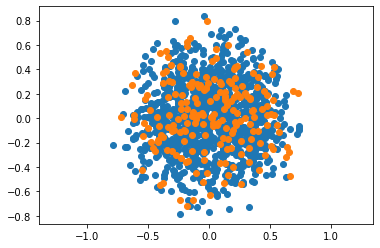

In [7]:
fig, ax = plt.subplots()
ax.scatter(X_domain[:, 0], X_domain[:, 1], label='Interior nodes')
ax.scatter(X_boundary[:, 0], X_boundary[:, 1], label='Boundary nodes')
ax.axis('equal')
plt.show()

In [8]:
sol_init = onp.random.randn(N_domain,1)
sigma = onp.sqrt(d)/4
nugget = 0.0
sol = GPsolver(X_domain, X_boundary, sigma, nugget, sol_init, GN_step = 6)

In [9]:
sol_truth = vmap(u)(X_domain)[:,onp.newaxis]
err = abs(sol-sol_truth)
print(onp.max(err))
print(onp.linalg.norm(err,'fro')/(N_domain))

0.5304582868614436
0.0025933358113841886


In [10]:
print(err[0:100])

[[0.07773021]
 [0.08303063]
 [0.11456717]
 [0.08636822]
 [0.00725675]
 [0.15518607]
 [0.03485816]
 [0.05833986]
 [0.21995994]
 [0.04978184]
 [0.00649389]
 [0.05905447]
 [0.04531643]
 [0.03122201]
 [0.05788695]
 [0.0909599 ]
 [0.00390547]
 [0.01138142]
 [0.12742396]
 [0.10055364]
 [0.13366979]
 [0.22653467]
 [0.06901483]
 [0.09667244]
 [0.04175229]
 [0.02846939]
 [0.02511704]
 [0.06955221]
 [0.009073  ]
 [0.08884196]
 [0.0343807 ]
 [0.1023687 ]
 [0.15096233]
 [0.04226315]
 [0.09874516]
 [0.10525424]
 [0.12595806]
 [0.03121201]
 [0.03396857]
 [0.05530843]
 [0.03633243]
 [0.01644715]
 [0.15160148]
 [0.09411761]
 [0.0775966 ]
 [0.00640243]
 [0.0362228 ]
 [0.00769249]
 [0.05503692]
 [0.1028792 ]
 [0.09975408]
 [0.01004032]
 [0.09523197]
 [0.16443687]
 [0.09663501]
 [0.03894964]
 [0.05275796]
 [0.01725496]
 [0.03491639]
 [0.0754835 ]
 [0.10506626]
 [0.07530257]
 [0.12265553]
 [0.11119962]
 [0.04710139]
 [0.06721702]
 [0.02616428]
 [0.09725129]
 [0.01271335]
 [0.06424825]
 [0.02306899]
 [0.09